# Segmentation of bones in MRIs based on 3D images of human knees

by [Paul-Louis Pröve](https://github.com/pietz)

## Dataset

The dataset that was available to me consisted of 145 three dimensional MRI images of human knees. The contestens were all northern german males with ages ranging from 14 to 20. The data came from two different sources. 

- 80 512x512x24 images provided by Jopp et al.
- 65 800x800x41 images that were recorded specifically for this project

Out of these 145 images I was also provided with 76 segmentation maps of the three visible bones. The femur, tibia and fibula had different labels to differentiate between the bones.

## 1 Imports & Functions

In [1]:
import numpy as np
import dask.array as da
from ipywidgets import FloatProgress
from IPython.display import display
from utils import *
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


## 2 Preprocess Data

This will read, resize and normalize the images from Epi and Jopp. Afterwards they are stored in a compressed NPY file easy access from disk.

In [ ]:
x, y, = load_data('data/*_Study/VOI_LABEL/*.mhd', label=3, size=(24,224,224), bias=True, norm=True)

In [ ]:
x, y = shuffle(x, y)

In [ ]:
np.save('data/x_3d_224', x)
np.save('data/y_3d_224_3', y)

In [ ]:
for i in tqdm(range(len(x))):
    x[i] = n4_bias_correction(x[i])[..., np.newaxis]

In [ ]:
y = y.sum(axis=4)[..., np.newaxis]

In [ ]:
np.save('data/y_3d_224_1', y)

In [ ]:
np.save('data/x_3d_192_bias', x)

## 3 Load Data

In [2]:
x = np.load('data/x_3d_bias.npy')
y = np.load('data/y_3d_3.npy')

In [3]:
x = to_2d(x)
y = to_2d(y)

In [4]:
print_info(x)
print_info(y)

(1824, 224, 224, 1) - Min: 0.0 - Mean: 0.27563 - Max: 1.5684
(1824, 224, 224, 3) - Min: 0.0 - Mean: 0.094055 - Max: 1.0


In [5]:
x_tr, y_tr, x_te, y_te = split(x, y, 0.8)

In [ ]:
x_tr, y_tr = augment(x_tr, y_tr, hori=True)

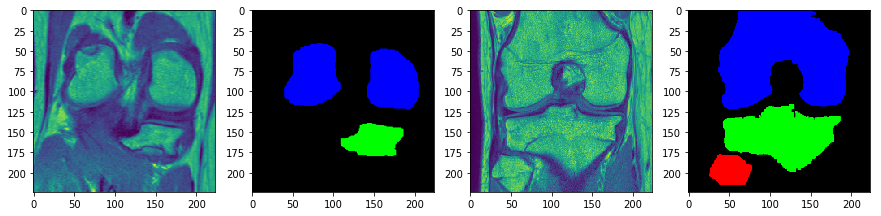

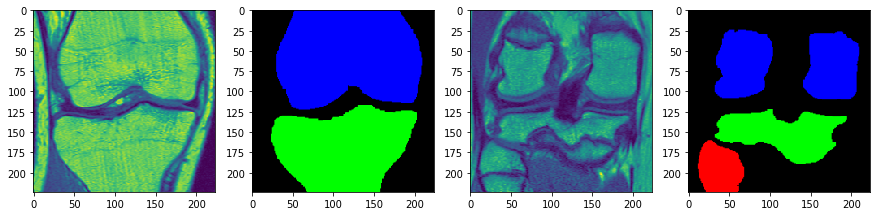

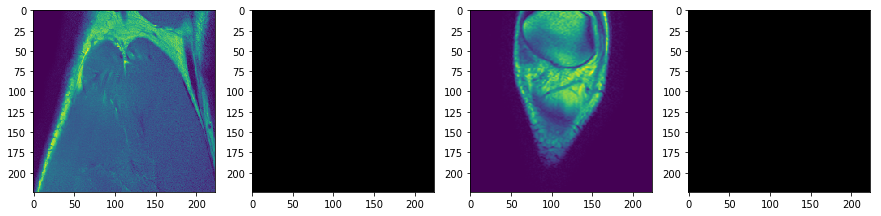

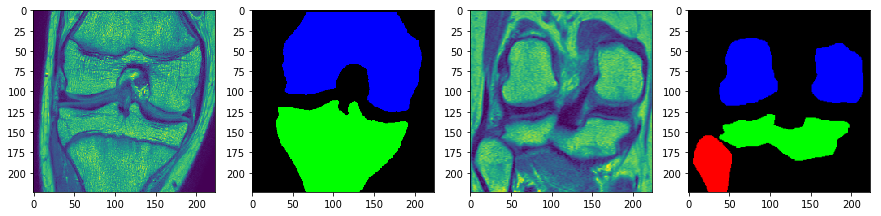

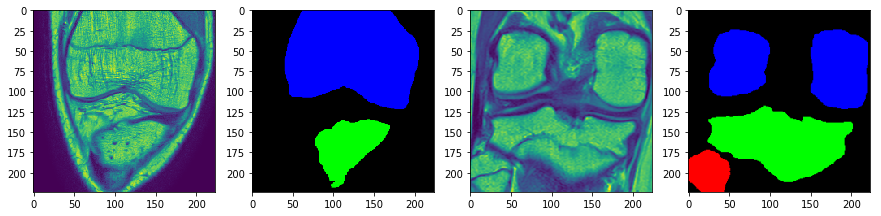

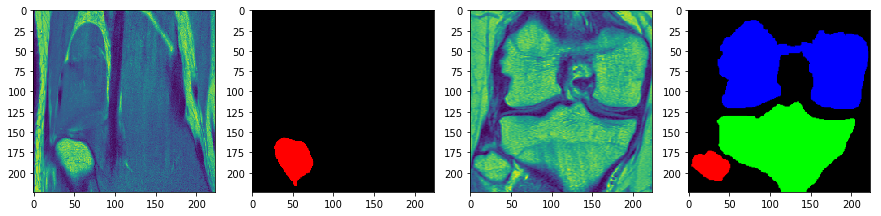

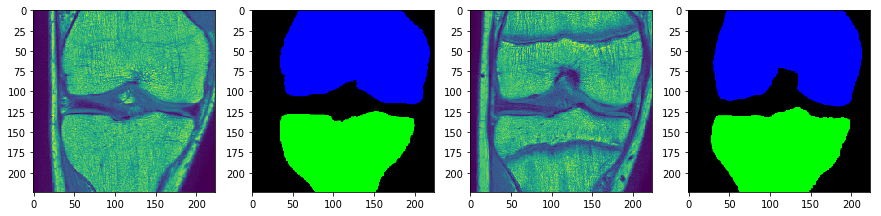

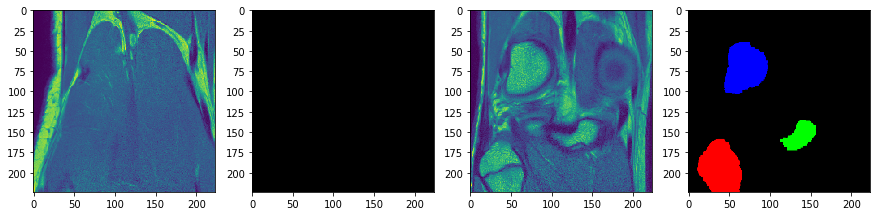

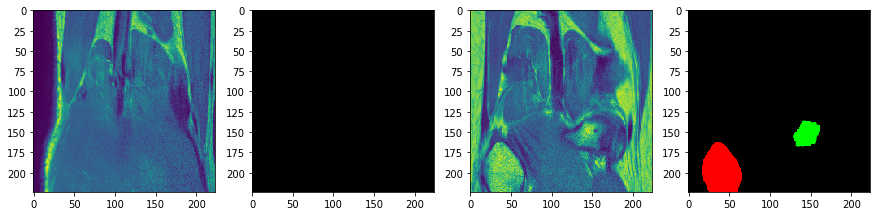

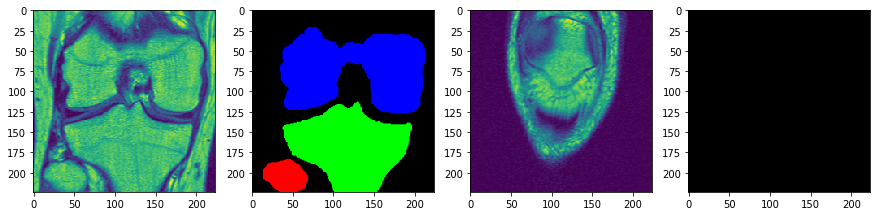

In [35]:
show_samples(x_tr, y_tr, 20)

## 4 Architecture

In [6]:
in_shape = x_tr.shape[1:]
out_ch = out_ch=y_tr.shape[-1]

In [ ]:
i = Input(shape=in_shape)
m = Conv2D(16, 3, dilation_rate=1, activation='elu', padding='same')(i)
m = Conv2D(16, 3, dilation_rate=1, activation='elu', padding='same')(m)
m = Conv2D(32, 3, dilation_rate=2, activation='elu', padding='same')(m)
m = Conv2D(48, 3, dilation_rate=4, activation='elu', padding='same')(m)
m = Conv2D(64, 3, dilation_rate=8, activation='elu', padding='same')(m)
m = Conv2D(96, 3, dilation_rate=16, activation='elu', padding='same')(m)
m = Conv2D(32, 3, dilation_rate=1, activation='elu', padding='same')(m)
o = Conv2D(out_ch, 1, activation='sigmoid')(m)
model = Model(inputs=i, outputs=o)

U-Net Variant

In [28]:
def unet2(acti='elu', ch=32):
    i = Input(shape=in_shape)
    l1 = Conv2D(ch, 3, activation=acti, dilation_rate=1, padding='same')(i)
    l1 = Conv2D(ch, 3, activation=acti, dilation_rate=1, padding='same')(l1)
    l2 = MaxPooling2D()(l1)
    l2 = Conv2D(ch, 3, activation=acti, dilation_rate=2, padding='same')(l2)
    l2 = Conv2D(ch, 3, activation=acti, dilation_rate=2, padding='same')(l2)
    l3 = MaxPooling2D()(l2)
    l3 = Conv2D(ch, 3, activation=acti, dilation_rate=4, padding='same')(l3)
    l3 = Conv2D(ch, 3, activation=acti, dilation_rate=4, padding='same')(l3)
    l4 = MaxPooling2D()(l3)
    l4 = Conv2D(ch, 3, activation=acti, dilation_rate=8, padding='same')(l4)
    l4 = Conv2D(ch, 3, activation=acti, dilation_rate=8, padding='same')(l4)
    m = MaxPooling2D()(l4)
    m = Conv2D(ch, 3, activation=acti, padding='same')(m)
    m = Dropout(0.5)(m)
    m = Conv2D(ch, 3, activation=acti, padding='same')(m)
    r4 = UpSampling2D()(m)
    r4 = Conv2D(ch, 2, activation=acti, padding='same')(r4)
    r4 = Concatenate(axis=3)([l4, r4])
    r4 = Conv2D(ch, 3, activation=acti, padding='same')(r4)
    r4 = Conv2D(ch, 3, activation=acti, padding='same')(r4)
    r3 = UpSampling2D()(r4)
    r3 = Conv2D(ch, 2, activation=acti, padding='same')(r3)
    r3 = Concatenate(axis=3)([l3, r3])
    r3 = Conv2D(ch, 3, activation=acti, padding='same')(r3)
    r3 = Conv2D(ch, 3, activation=acti, padding='same')(r3)
    r2 = UpSampling2D()(r3)
    r2 = Conv2D(ch, 2, activation=acti, padding='same')(r2)
    r2 = Concatenate(axis=3)([l2, r2])
    r2 = Conv2D(ch, 3, activation=acti, padding='same')(r2)
    r2 = Conv2D(ch, 3, activation=acti, padding='same')(r2)
    r1 = UpSampling2D()(r2)
    r1 = Conv2D(ch, 2, activation=acti, padding='same')(r1)
    r1 = Concatenate(axis=3)([l1, r1])
    r1 = Conv2D(ch, 3, activation=acti, padding='same')(r1)
    r1 = Conv2D(ch, 3, activation=acti, padding='same')(r1)
    o = Conv2D(out_ch, 1, activation='sigmoid')(r1)
    return Model(inputs=i, outputs=o)

In [40]:
model = unet2()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_12 (InputLayer)            (None, 224, 224, 1)   0                                            
____________________________________________________________________________________________________
conv2d_266 (Conv2D)              (None, 224, 224, 32)  320         input_12[0][0]                   
____________________________________________________________________________________________________
batch_normalization_19 (BatchNor (None, 224, 224, 32)  128         conv2d_266[0][0]                 
____________________________________________________________________________________________________
conv2d_267 (Conv2D)              (None, 224, 224, 32)  9248        batch_normalization_19[0][0]     
___________________________________________________________________________________________

## 5 Training

In [ ]:
model.load_weights('weights/seg2d_9739_224_32_4_1_0.25_1_bias_duo.h5')

In [ ]:
model = UNet_3D(in_shape, n_out=y_tr.shape[-1], dim=20, depth=4, factor=1, acti='elu')
model.compile(optimizer=Adam(lr=0.001, decay=0.001), loss=f1_loss, metrics=[bce_img])
tb = TensorBoard()
mc = ModelCheckpoint('weights/seg3d_224_20_4_1_0_1.h5', 
                     save_best_only=True, 
                     save_weights_only=True)
es = EarlyStopping(patience=9)
model.fit(x_tr, y_tr, validation_data=(x_te, y_te), epochs=150, batch_size=3, callbacks=[mc, es, tb])

In [11]:
model = unet2()
model.compile(optimizer=Adam(lr=0.001, decay=0.001), loss=f1_loss, metrics=[bce_img])
tb = TensorBoard(log_dir='./logs/f1_224_1')
mc = ModelCheckpoint('weights/seg2d_224_32_4_1_0.5_1_f1.h5', 
                     save_best_only=True, 
                     save_weights_only=True)
es = EarlyStopping(patience=9)
model.fit(x_tr, y_tr, validation_data=(x_te, y_te), epochs=100, batch_size=32, callbacks=[mc, es, tb])

Train on 1459 samples, validate on 365 samples
Epoch 1/100
1459/1459 [==============================] - 36s - loss: 0.4313 - bce_img: 3.7208 - val_loss: 0.3138 - val_bce_img: 2.4135
Epoch 2/100
1459/1459 [==============================] - 31s - loss: 0.3175 - bce_img: 2.9570 - val_loss: 0.2880 - val_bce_img: 2.5523
Epoch 3/100
1459/1459 [==============================] - 31s - loss: 0.2750 - bce_img: 2.3776 - val_loss: 0.2647 - val_bce_img: 2.4111
Epoch 4/100
1459/1459 [==============================] - 32s - loss: 0.2368 - bce_img: 1.9088 - val_loss: 0.1888 - val_bce_img: 1.4912
Epoch 5/100
1459/1459 [==============================] - 31s - loss: 0.1772 - bce_img: 1.3789 - val_loss: 0.1265 - val_bce_img: 0.8385
Epoch 6/100
1459/1459 [==============================] - 32s - loss: 0.1304 - bce_img: 0.9430 - val_loss: 0.1097 - val_bce_img: 0.5787
Epoch 7/100
1459/1459 [==============================] - 32s - loss: 0.1102 - bce_img: 0.7473 - val_loss: 0.0823 - val_bce_img: 0.5469
Epoch 8/

In [28]:
model = unet2()
model.compile(optimizer=Adam(lr=0.001, decay=0.001), loss=f1_loss, metrics=[bce_img])
tb = TensorBoard(log_dir='./logs/f1_32-64_224_1')
mc = ModelCheckpoint('weights/seg2d_224_32_4_1_0.5_1_f1_32-64.h5', 
                     save_best_only=True, 
                     save_weights_only=True)
es = EarlyStopping(patience=9)
model.fit(x_tr, y_tr, validation_data=(x_te, y_te), epochs=100, batch_size=32, callbacks=[mc, es, tb])

Train on 1459 samples, validate on 365 samples
Epoch 1/100
1459/1459 [==============================] - 41s - loss: 0.4224 - bce_img: 2.4098 - val_loss: 0.3455 - val_bce_img: 2.0098
Epoch 2/100
1459/1459 [==============================] - 36s - loss: 0.3302 - bce_img: 2.1276 - val_loss: 0.3281 - val_bce_img: 1.7813
Epoch 3/100
1459/1459 [==============================] - 36s - loss: 0.3903 - bce_img: 4.4274 - val_loss: 0.4998 - val_bce_img: 8.4867
Epoch 4/100
1459/1459 [==============================] - 36s - loss: 0.3811 - bce_img: 4.2856 - val_loss: 0.3148 - val_bce_img: 2.2940
Epoch 5/100
1459/1459 [==============================] - 36s - loss: 0.3252 - bce_img: 2.6244 - val_loss: 0.3565 - val_bce_img: 2.1235
Epoch 6/100
1459/1459 [==============================] - 36s - loss: 0.2801 - bce_img: 2.2263 - val_loss: 0.2601 - val_bce_img: 1.9831
Epoch 7/100
1459/1459 [==============================] - 36s - loss: 0.2655 - bce_img: 2.0277 - val_loss: 0.2527 - val_bce_img: 1.8687
Epoch 8/

In [ ]:
model = unet2()
model.compile(optimizer=Adam(lr=0.001, decay=0.001), loss=f1_loss, metrics=[bce_img])
tb = TensorBoard(log_dir='./logs/f1_48_224_1')
mc = ModelCheckpoint('weights/seg2d_224_48_4_1_0.5_1_f1_.h5', 
                     save_best_only=True, 
                     save_weights_only=True)
es = EarlyStopping(patience=9)
model.fit(x_tr, y_tr, validation_data=(x_te, y_te), epochs=100, batch_size=28, callbacks=[mc, es, tb])

Train on 1459 samples, validate on 365 samples
Epoch 1/100
1459/1459 [==============================] - 55s - loss: 0.4434 - bce_img: 3.6457 - val_loss: 0.3341 - val_bce_img: 2.5700
Epoch 2/100
1459/1459 [==============================] - 48s - loss: 0.3241 - bce_img: 2.6929 - val_loss: 0.3206 - val_bce_img: 3.2609
Epoch 3/100
1459/1459 [==============================] - 48s - loss: 0.2674 - bce_img: 2.1285 - val_loss: 0.2631 - val_bce_img: 2.1004
Epoch 4/100
1459/1459 [==============================] - 48s - loss: 0.2307 - bce_img: 1.9096 - val_loss: 0.2331 - val_bce_img: 1.5436
Epoch 5/100
1459/1459 [==============================] - 48s - loss: 0.2115 - bce_img: 1.6693 - val_loss: 0.1699 - val_bce_img: 1.3179
Epoch 6/100
1459/1459 [==============================] - 48s - loss: 0.1420 - bce_img: 1.1296 - val_loss: 0.1150 - val_bce_img: 0.8470
Epoch 7/100
1459/1459 [==============================] - 48s - loss: 0.1020 - bce_img: 0.7500 - val_loss: 0.0868 - val_bce_img: 0.5664
Epoch 8/

In [ ]:
model = unet2()
model.compile(optimizer=Adam(lr=0.001, decay=0.001), loss=f1_loss, metrics=[bce_img])
tb = TensorBoard(log_dir='./logs/f1_224_sep_1')
mc = ModelCheckpoint('weights/seg2d_224_32_4_1_0.5_1_f1_dil.h5', 
                     save_best_only=True, 
                     save_weights_only=True)
es = EarlyStopping(patience=9)
model.fit(x_tr, y_tr, validation_data=(x_te, y_te), epochs=100, batch_size=32, callbacks=[mc, es, tb])

Train on 1459 samples, validate on 365 samples
Epoch 1/100
1459/1459 [==============================] - 38s - loss: 0.3670 - bce_img: 2.4975 - val_loss: 0.2960 - val_bce_img: 1.9171
Epoch 2/100
1459/1459 [==============================] - 32s - loss: 0.1994 - bce_img: 1.5317 - val_loss: 0.1345 - val_bce_img: 0.9286
Epoch 3/100
1459/1459 [==============================] - 32s - loss: 0.1212 - bce_img: 0.8731 - val_loss: 0.1009 - val_bce_img: 0.6247
Epoch 4/100
1459/1459 [==============================] - 32s - loss: 0.0828 - bce_img: 0.5182 - val_loss: 0.0596 - val_bce_img: 0.3470
Epoch 5/100
1459/1459 [==============================] - 33s - loss: 0.0592 - bce_img: 0.3452 - val_loss: 0.0510 - val_bce_img: 0.2931
Epoch 6/100
1459/1459 [==============================] - 32s - loss: 0.0521 - bce_img: 0.3274 - val_loss: 0.0518 - val_bce_img: 0.3291
Epoch 7/100
1459/1459 [==============================] - 32s - loss: 0.0466 - bce_img: 0.2929 - val_loss: 0.0454 - val_bce_img: 0.2887
Epoch 8/

depth 5 resulted in very high overfitting that it never recovered from. it was stopped after 30 epochs.
growth rates of more than 1 also gave the network more room to overfit and never resulted in abover 90% IoU. 

For the segmentation I built on two U-Net like architectures. Both were very small variants of the original U-Net because I had so little data to train on. Using the original with its millions of parameters I would have started to overfit very early. Both models had a depth of 4 and Dropout of 0.2 in the encoding and decoding parts. Network A had 16 input channels that were multiplied by 1.5 for every layer down. Network B had 32 channels all the way down the network. This was inspired by a Kaggle competition solution from deepense.io who noticed no improvement when increasing the number of channels down the network. Network A had 340k parameters opposed to the 210k in Network B. The training time for 1 epoch was 

    - Network A: 16 channels, growth rate 1.5, 340k parameters, 27s per epoch
    - Network B: 32 channels, growth rate 1.0, 210k parameters, 37s per epoch
    
As we can see here the number of parameters has no linear effect on the time per epoch. Most of the time it'S the first layer that puts a bottleneck on all following layers. After 85 epochs Network B reached a validation accuracy of 95,23% IoU and stopped improving from here on. With 95,98% on the training set it also overfitted just a little. Network A was stopped after 60 epochs were the training validation was similar (95,66%) to Network B. However, the validation score was 92,99% indicating that it already overfitted quite a bit. This shows that the higher number of parameters have a negative effect when it comes to overfitting. It also shows that deeper layers don't benefit from increasing channel sizes.

## 5 Verification

In [8]:
model = unet2()

In [11]:
model.compile(optimizer=Adam(lr=0.001, decay=0.001), loss=f1_loss, metrics=[bce_img])

In [9]:
model.load_weights('weights/seg2d_224_48_4_1_0.5_1_f1.h5')

In [12]:
model.evaluate(x_te, y_te, batch_size=4)

365/365 [==============================] - 4s     


[0.07881056805179544, 0.16737121824876777]

In [13]:
f1m = model.predict(x_te, batch_size=4, verbose=1)

364/365 [============================>.] - ETA: 0s

In [15]:
f1m[f1m > 0.5] = 1
f1m[f1m < 0.5] = 0

In [16]:
p = f1m
inter = y_te.astype('float32') * p
dice = (2*inter.sum() + 1.) / (y_te.astype('float32').sum() + p.sum() + 1.)
precision = (inter.sum() + 1.) / (p.sum() + 1.)
recall = (inter.sum() + 1.) / (y_te.astype('float32').sum() + 1.)
iou = (inter.sum() + 1.) / (y_te.astype('float32').sum() + p.sum() - inter.sum() + 1.)
print('DICE:      ' + str(dice))
print('Precision: ' + str(precision))
print('Recall:    ' + str(recall))
print('IoU:       ' + str(iou))

DICE:      0.977038963154
Precision: 0.973770923319
Recall:    0.980329016898
IoU:       0.955108681912


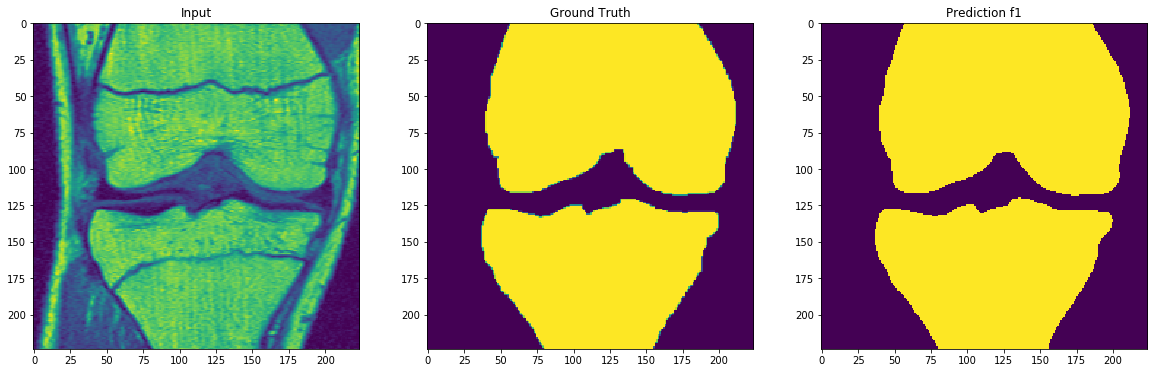

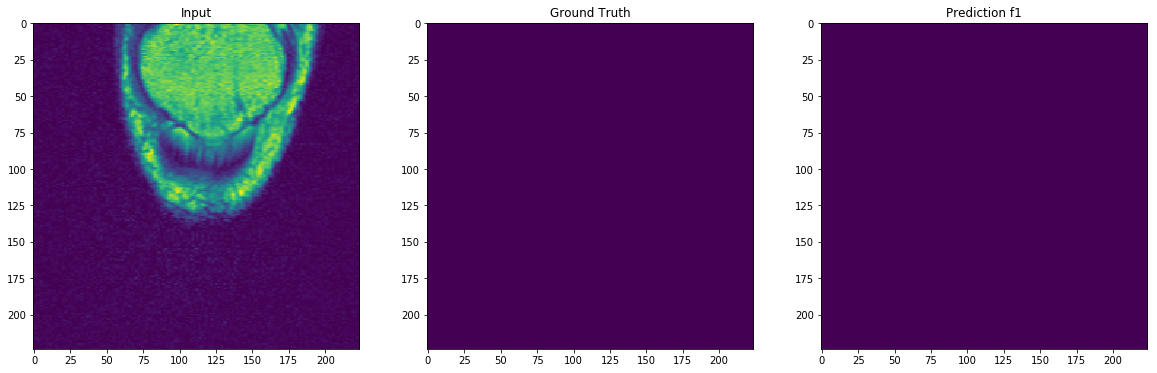

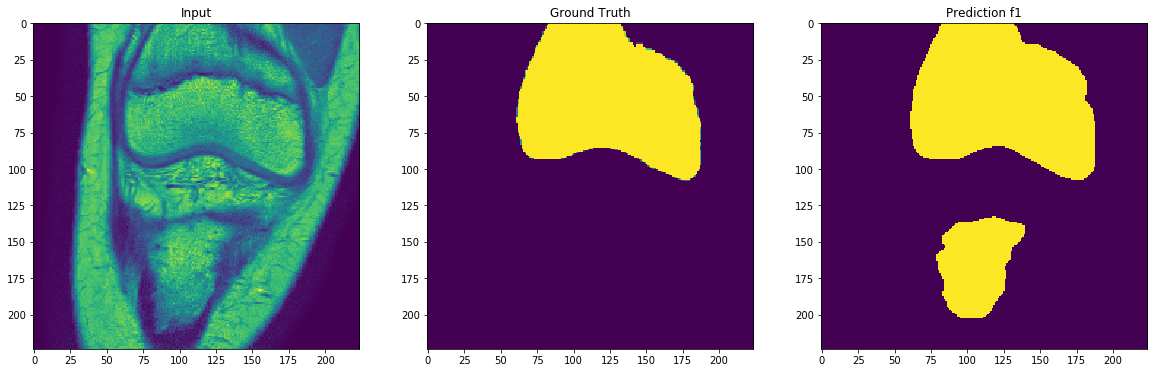

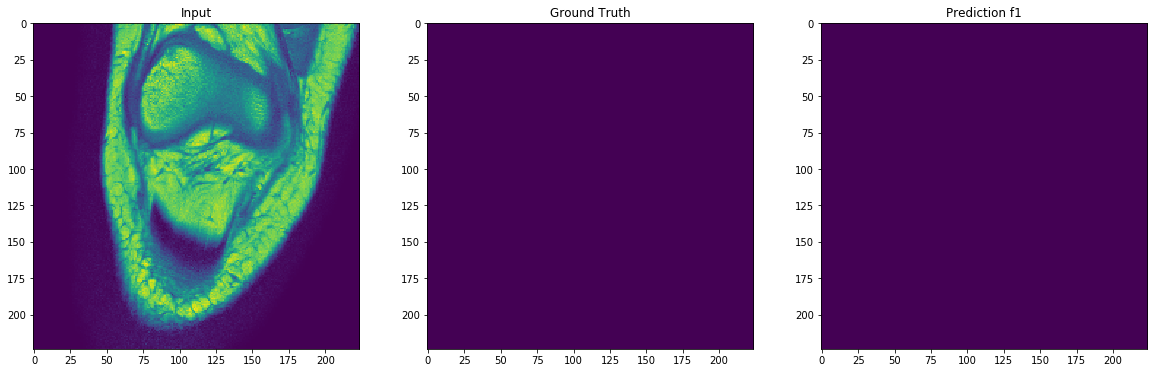

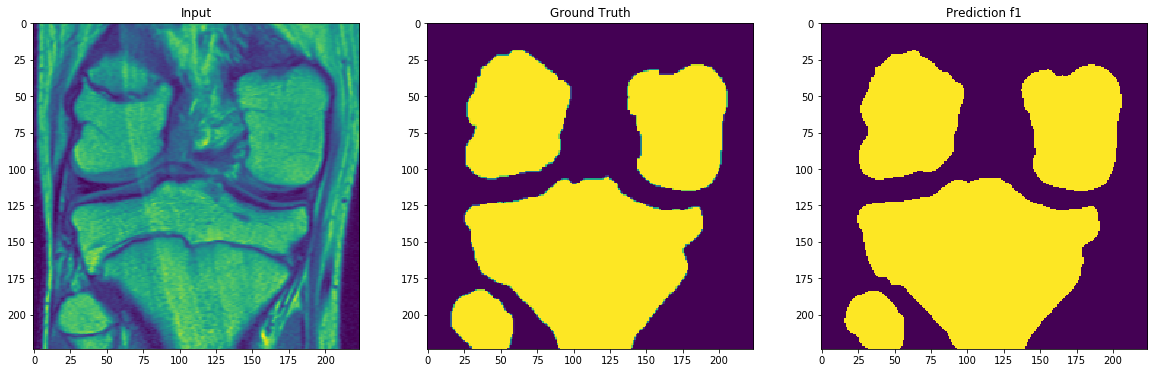

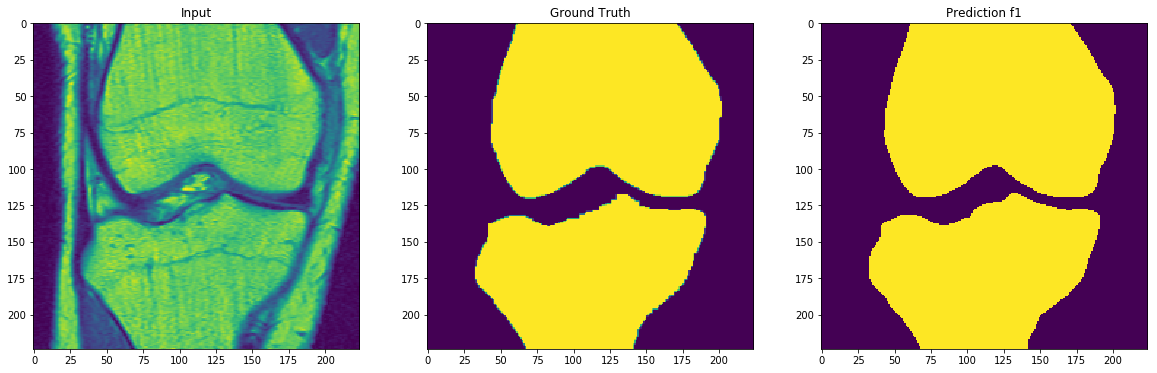

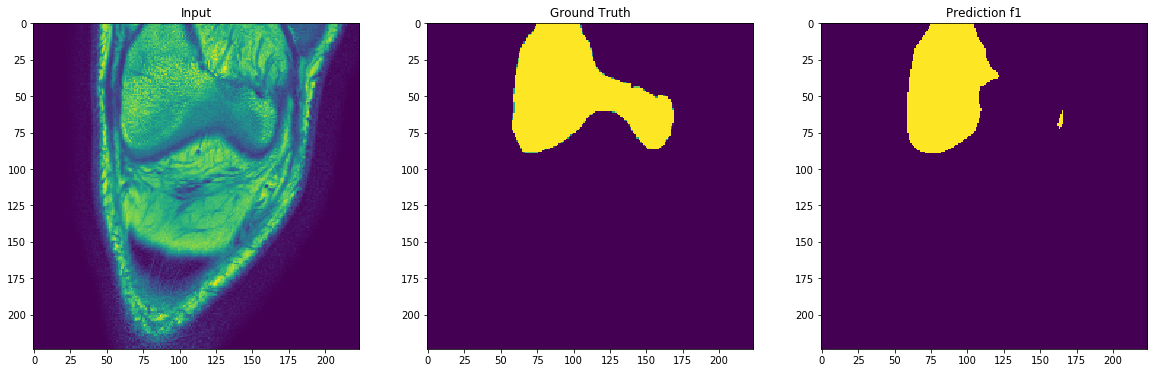

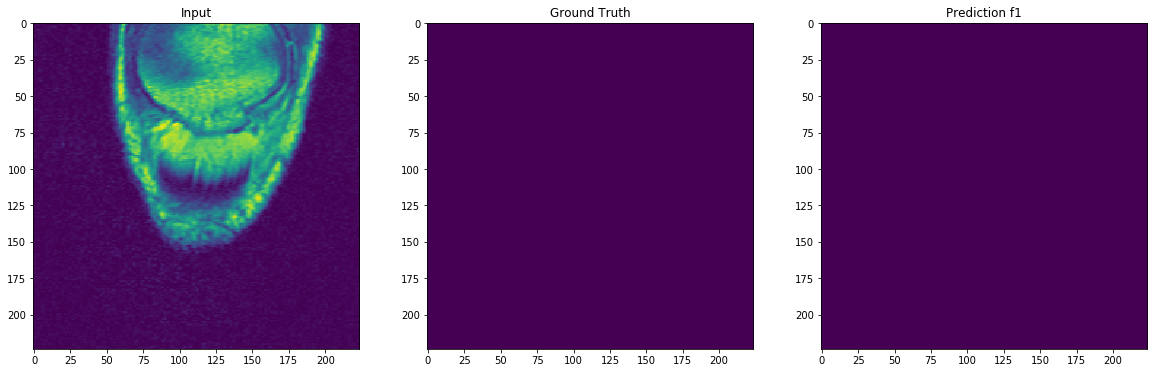

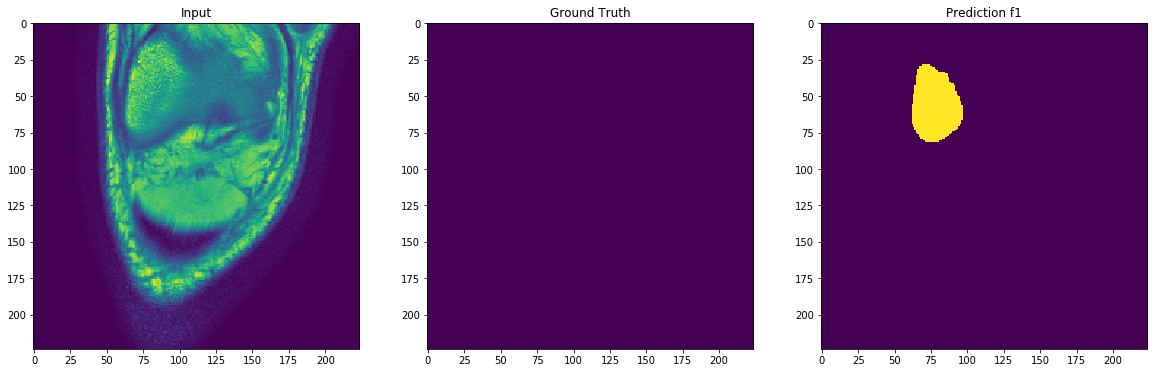

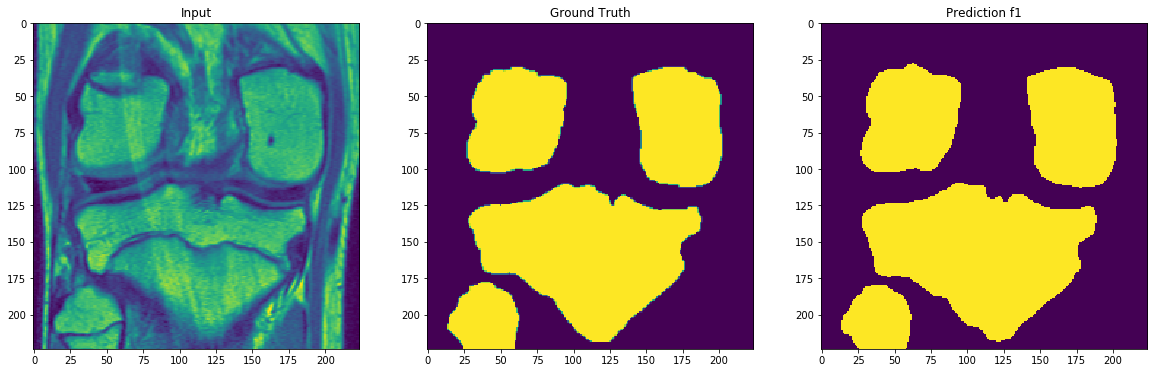

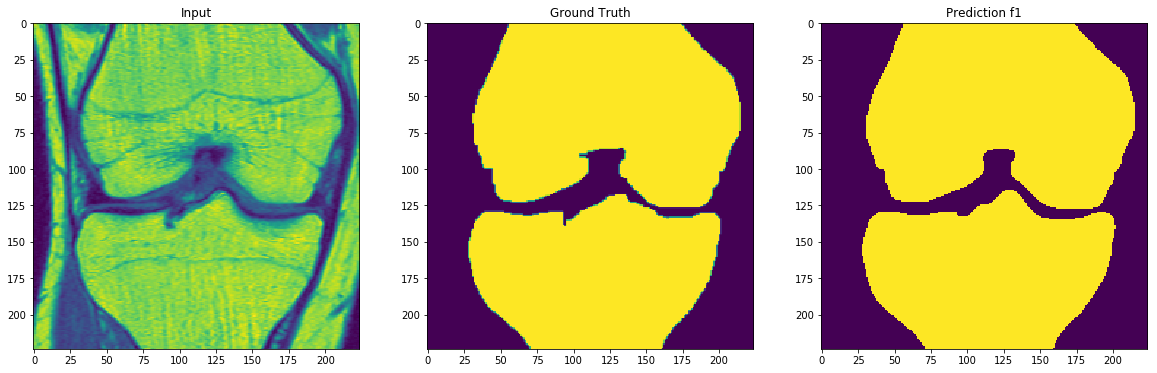

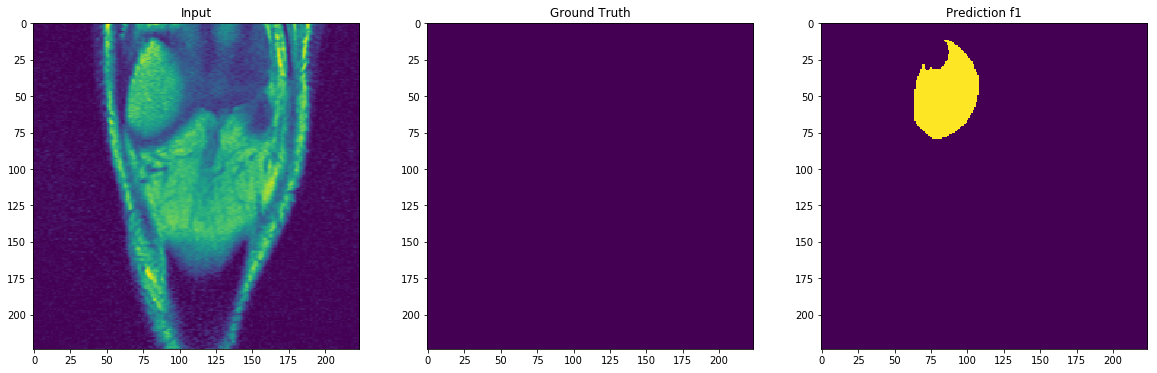

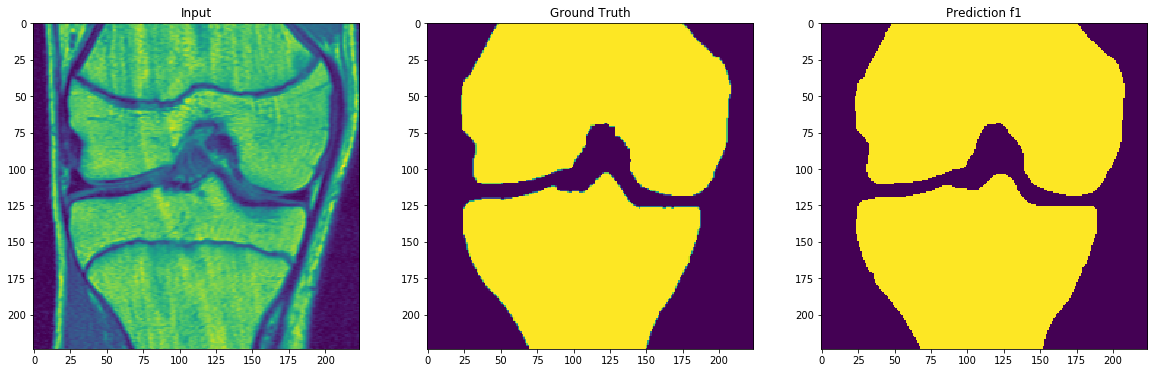

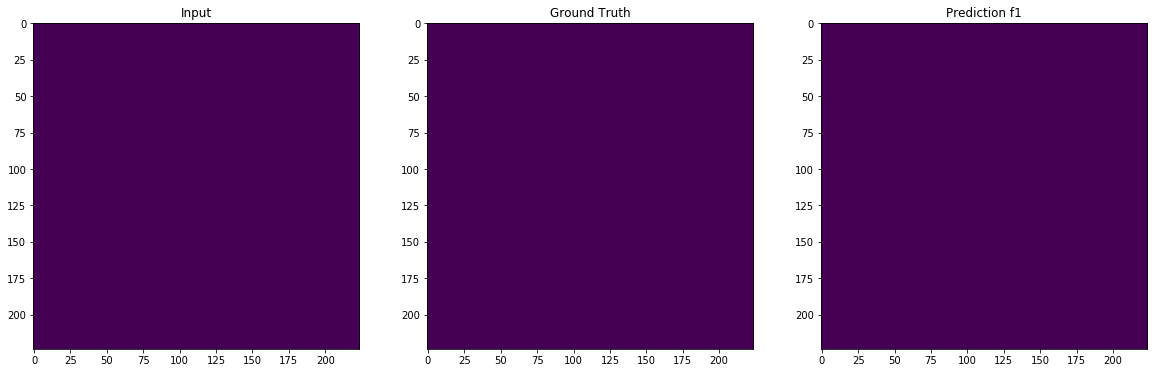

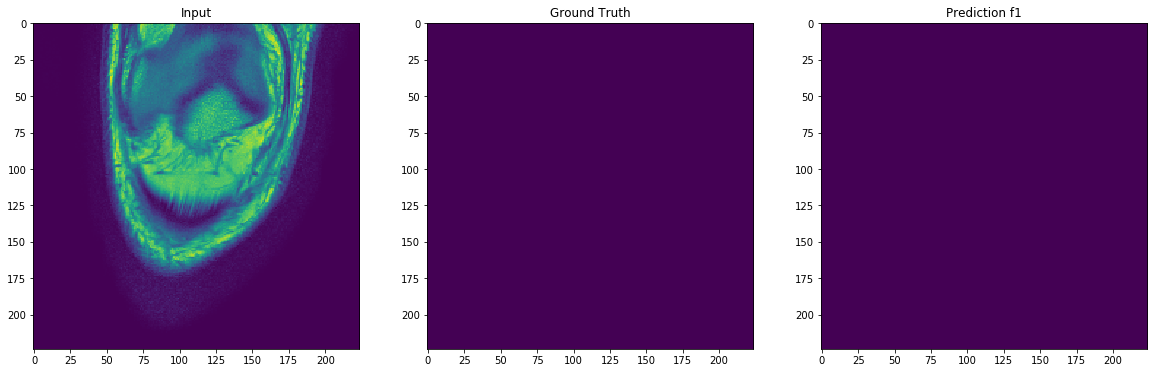

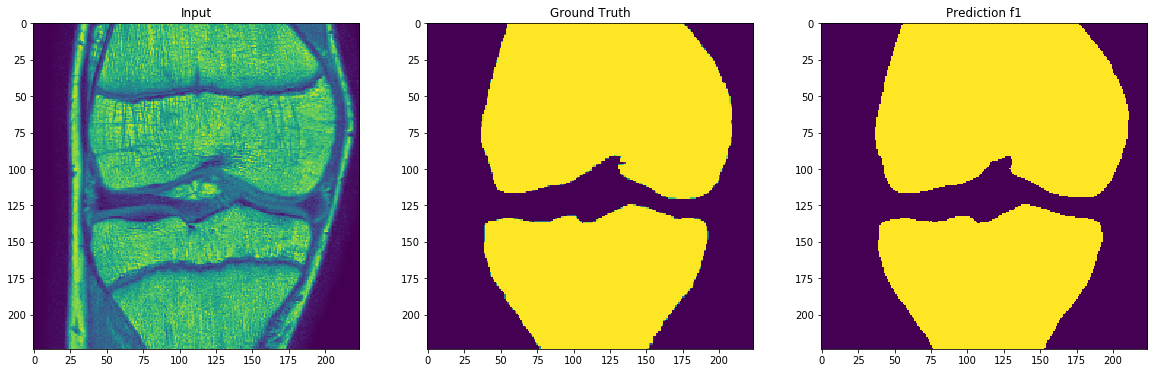

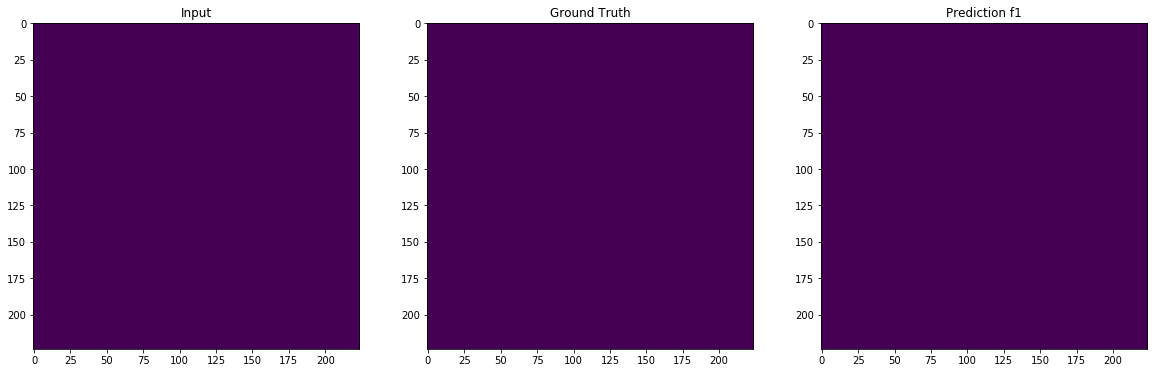

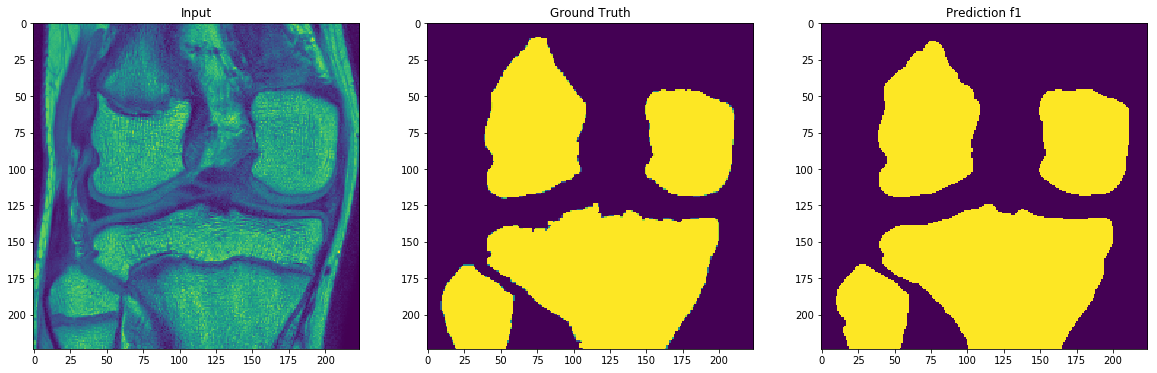

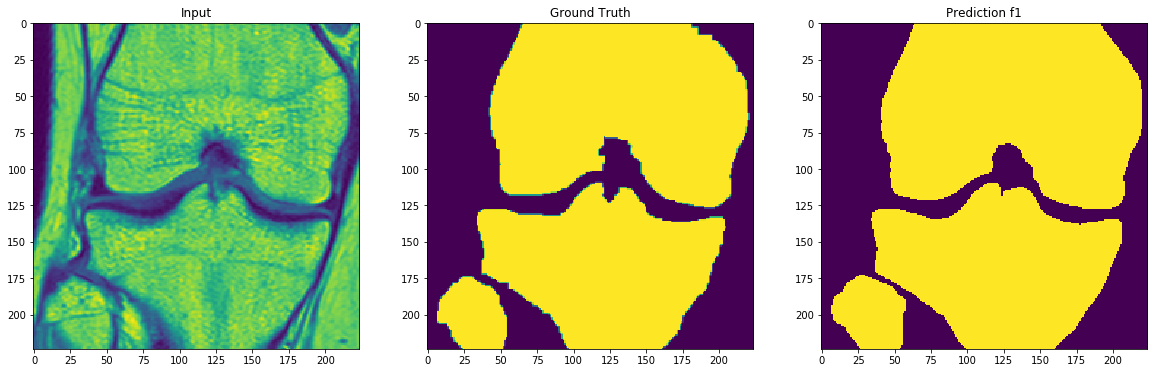

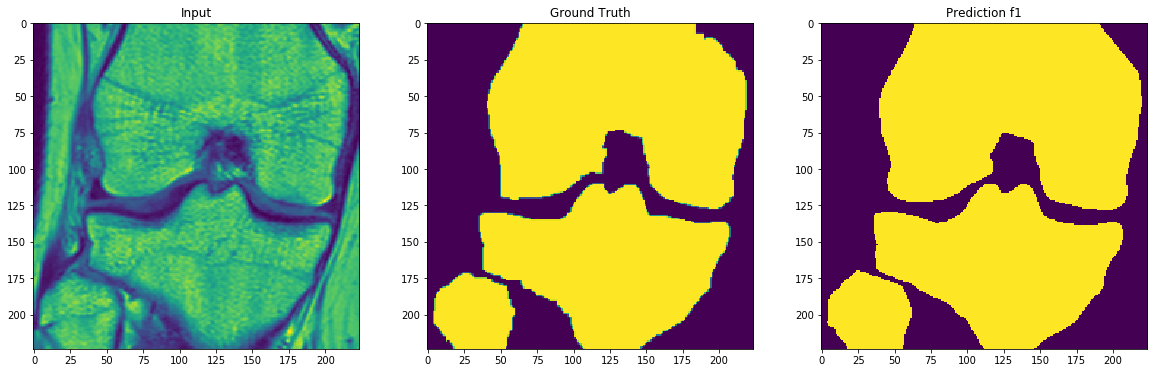

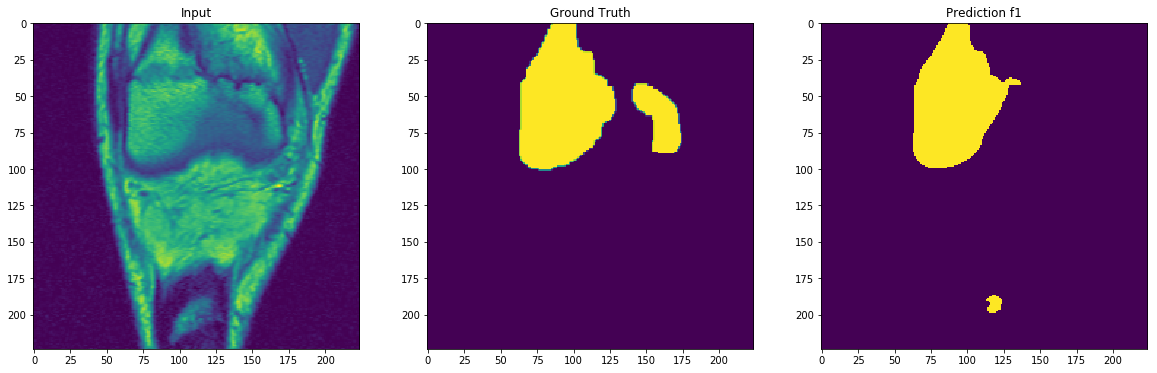

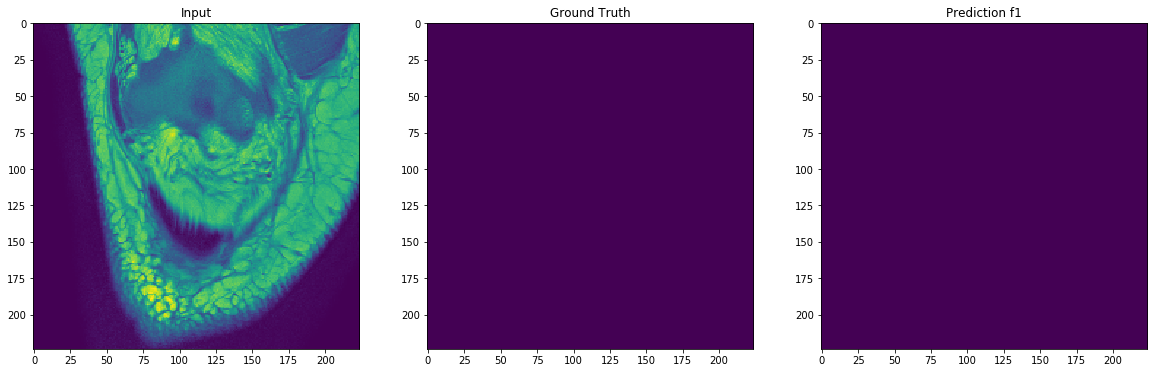

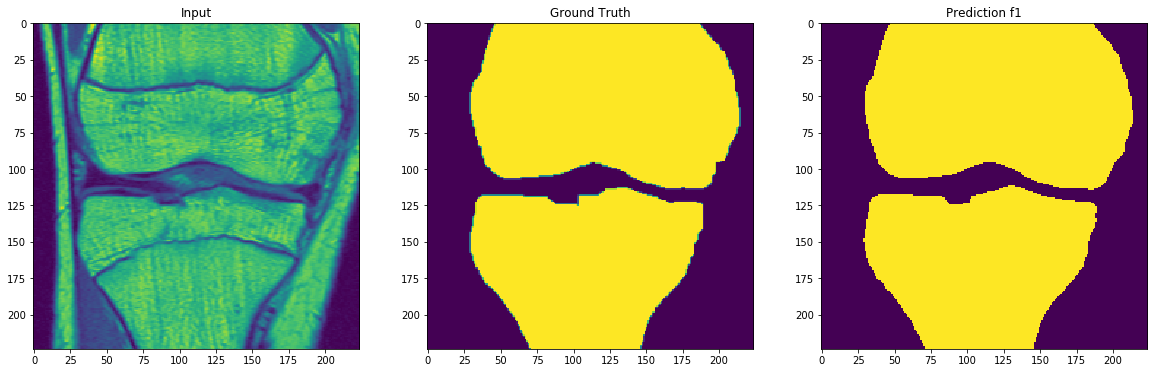

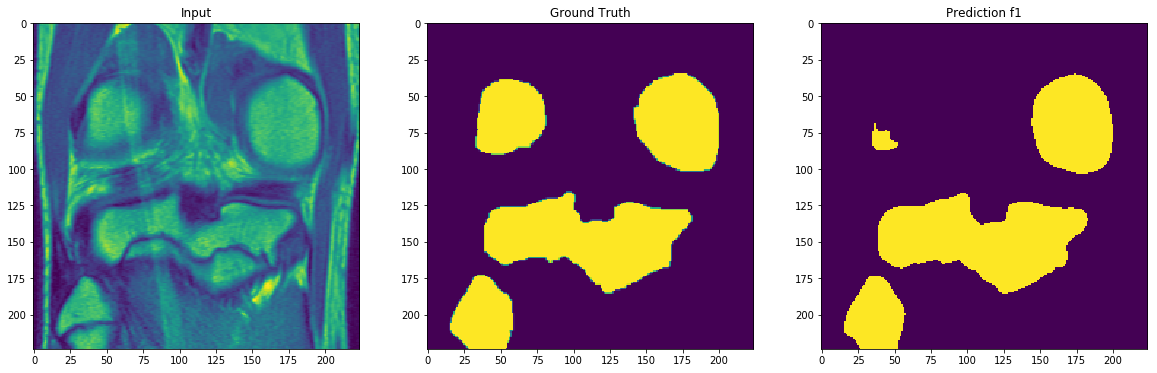

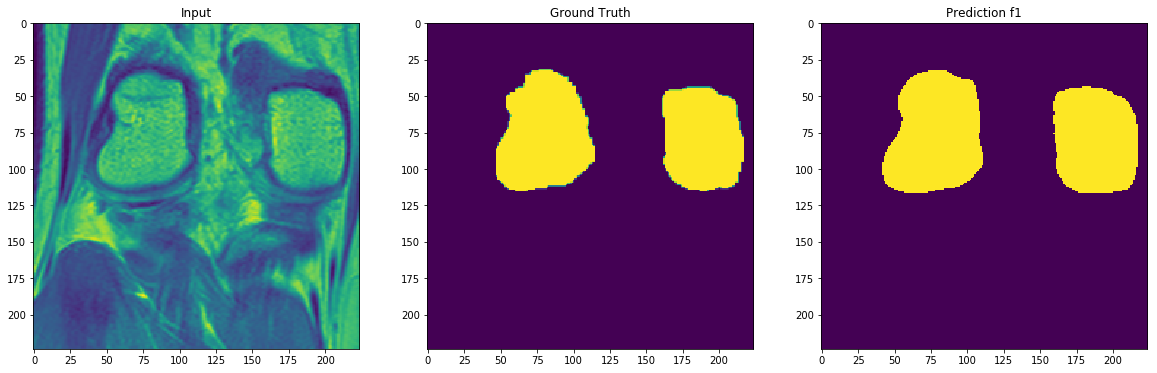

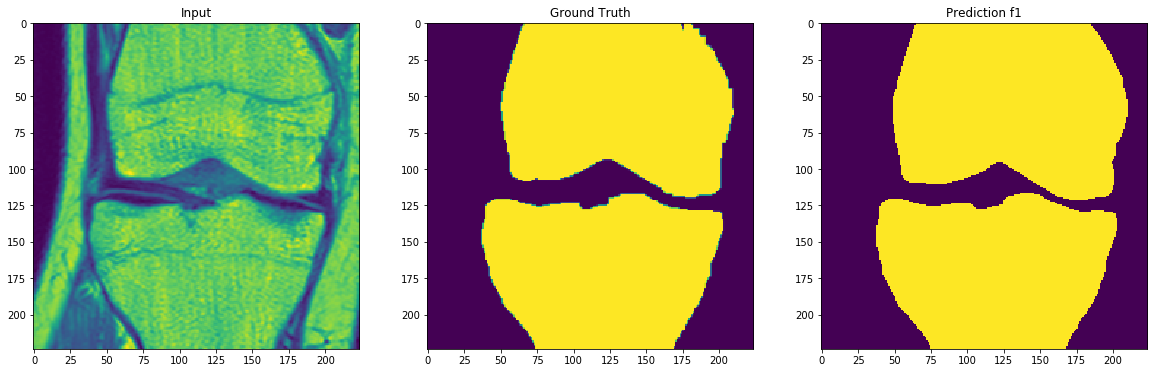

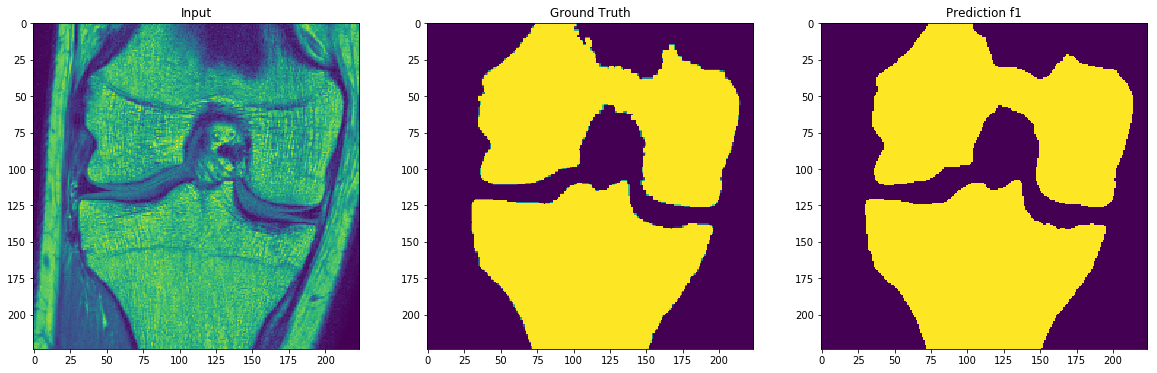

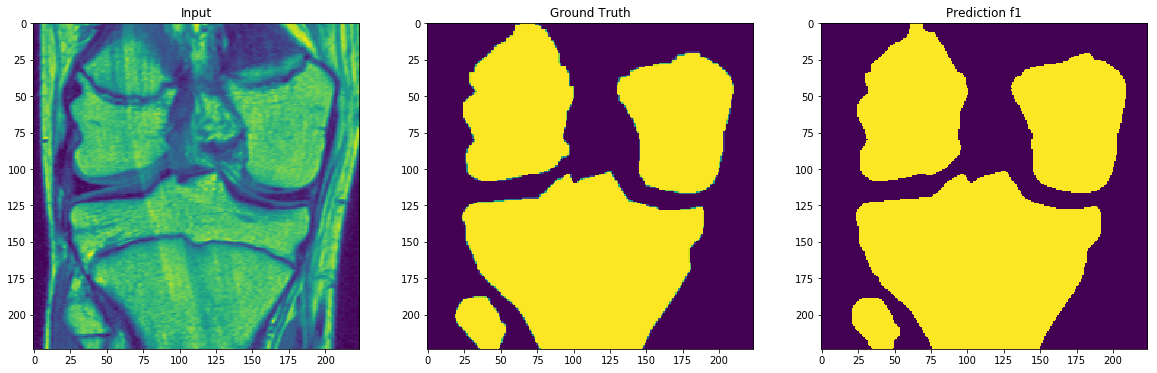

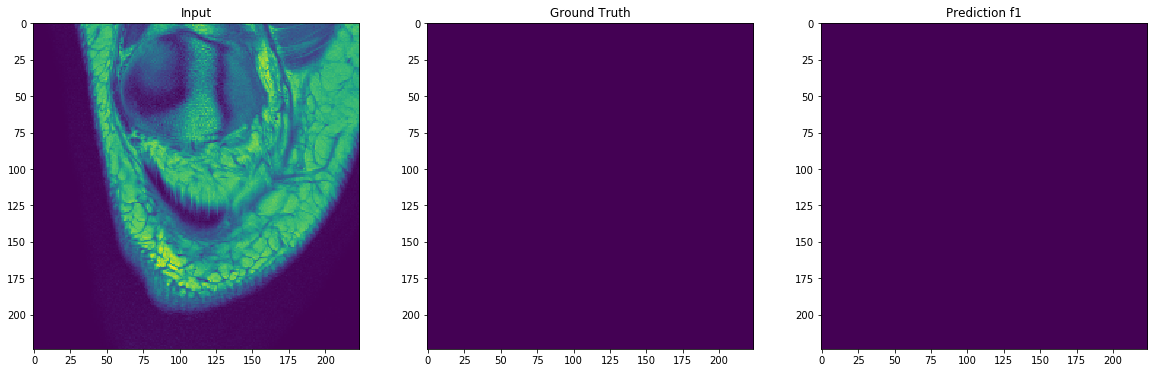

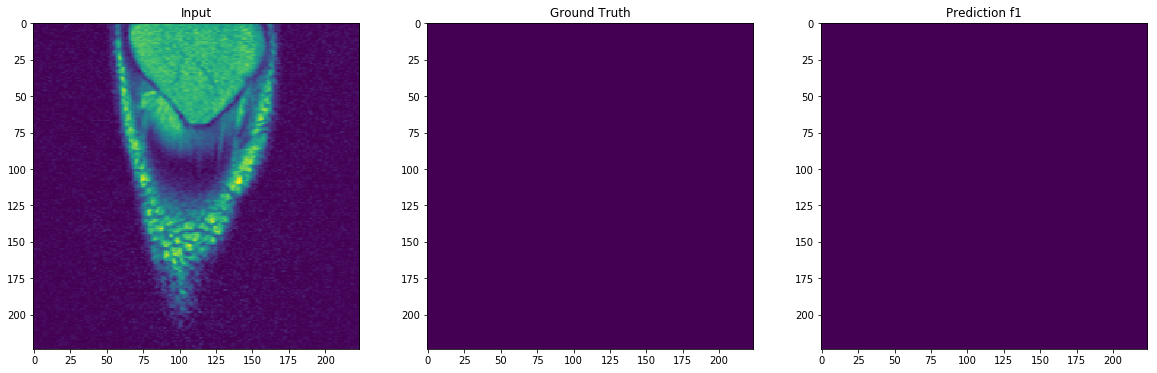

In [17]:
rndm = np.random.permutation(len(x_te))
for i in range(0,30):
    plt.figure(figsize=(20, 6))
    plt.subplot(1,3,1)
    plt.title('Input')
    plt.imshow(x_te[rndm[i], ..., 0].astype('float32'))
    plt.subplot(1,3,2)
    plt.title('Ground Truth')
    plt.imshow(y_te[rndm[i], ..., 0].astype('float32'))
    plt.subplot(1,3,3)
    plt.title('Prediction f1')
    plt.imshow(f1m[rndm[i], ..., 0].astype('float32'))
    plt.show()
